
## Basic settings and parameters

`EBTgymEnv()` class comes preconfigured for quick setting. Basicaly one need to provide at least data file keyword argument to set it up. 

BTgym relies on Backtrader framework for actual environment rendering. Environment customisation can be done either via setting basic set of parameters, inherited from Backtrader computational engine, or passing to env. complete engine  subclass. This example covers basic setting, while  later option gives complete control over backtasting logic and environment becames as flexible as Backtrader itself.
 
Besides, there is another bunch of vital options related to reinforcement learning setting: observation and action space parameters and episode setting.
 
One can eyeball internal environment parameters by looking at nested  `MyEnvironment.params` dictionary consisting of these subdictionaries:
   - `params['dataset']`,  
   - `params['engine']`,
   - `params['strategy']`,
   - `params['render']`.
 
- Look at source files for exact parameters descriptions, since complete doc. reference is yet to come.
##### Here all parameters are left to defaults values:

In [1]:
from btgym import BTgymEnv

# Handy function:
def under_the_hood(env):
    """Shows environment internals."""
    for attr in ['dataset','strategy','engine','renderer','network_address']:
        print ('\nEnv.{}: {}'.format(attr, getattr(env, attr)))

    for params_name, params_dict in env.params.items():
        print('\nParameters [{}]: '.format(params_name))
        for key, value in params_dict.items():
            print('{} : {}'.format(key,value))

In [2]:
# Simpliest trading environment,
# using year-long dataset of one minute bars for EUR/USD currency pair: 

 
MyEnvironment = BTgymEnv(filename='./data/DAT_ASCII_EURUSD_M1_2016.csv',)

# Print environment configuration:
under_the_hood(MyEnvironment)

# Clean up:
MyEnvironment.close()


Env.dataset: <btgym.datafeed.derivative.BTgymDataset object at 0x7fc30960afd0>

Env.strategy: <class 'btgym.strategy.base.BTgymBaseStrategy'>

Env.engine: <backtrader.cerebro.Cerebro object at 0x7fc3095a5b00>

Env.renderer: <btgym.rendering.renderer.BTgymRendering object at 0x7fc3095a5c18>

Env.network_address: tcp://127.0.0.1:5500

Parameters [engine]: 
start_cash : 10.0
broker_commission : 0.001
fixed_stake : 10

Parameters [dataset]: 
filename : None
sep : ;
header : 0
index_col : 0
parse_dates : True
names : ['open', 'high', 'low', 'close', 'volume']
timeframe : 1
datetime : 0
open : 1
high : 2
low : 3
close : 4
volume : -1
openinterest : -1
sample_duration : {'days': 0, 'hours': 23, 'minutes': 55}
start_weekdays : [0, 1, 2, 3, 4, 5, 6]
start_00 : False
time_gap : {'days': 0, 'hours': 6}
expanding : False
test_period : {'days': 0, 'hours': 0, 'minutes': 0}

Parameters [strategy]: 
state_shape : {'raw_state': Box(4, 4), 'metadata': Dict(first_row:Box(), sample_num:Box(), timestamp:

*****
### More control:
##### One can tweak environment setup by passing set of kwargs:

In [3]:
from gym import spaces

MyEnvironment = BTgymEnv(filename='../examples/data/DAT_ASCII_EURUSD_M1_2016.csv',
                         
                     # Dataset and single random episode related parameters:
                         
                         # We start trading on mondays, thuesdays and wednesdays:
                         start_weekdays=[0, 1, 2],
                         # Want total episode duration to be no more than 1 day 23h 55min:
                         episode_duration={'days': 1, 'hours': 23, 'minutes': 55},
                         # Want to start every episode at the begiining of the day:
                         start_00=True,
                         
                     # Broker and trade realted:
                         
                         # Set initial capital:
                         start_cash=100,
                         # Set broker commission as 0.2% of operation value:
                         broker_commission=0.002,
                         # We use fixed stake of size 10:
                         fixed_stake=10,
                         # We want stop episode if 30% of initial capital is lost:
                         drawdown_call=30,
                         
                     # RL environment related parameters:
                         
                         # Set observation shape. By convention, first dimension 
                         # is time embedding dimensionality;
                         # that's basically means we get sequence of 30 last  
                         # [o,h,l,c] candels as our one-step environment observation:
                         
                         state_shape=dict(raw=spaces.Box(low=0,high=1,shape=(30,4))),
                                          
                         # BTgym uses multi-modal observation space which is basically dictionary
                         # consisting of simple gym spaces (Box, discrete, etc.)
                         # For the built-in `raw_state` setting high and low is dummy, because
                         # environment will infer values from entire dataset statistic.
                         
                     # Other parameters:
                         
                         # Network port to use; note that using multiply environments at once reqires expliciltly
                         # setting different ports to avoid meesing up. If your jupyter kernel suddenly dies
                         # when running new environment - that's may be because of port conflict,
                         # or 'previous' environment instance (client-side) is still running.
                         # Don't panic, just clear up and restart kernel,
                         # or use env.close() to shut down all the services.
                         port=5555,
                         # Data-server port to use, same as above apply:
                         #data_port=4600,
                         # Be chatty: settting this to 1 makes environment report what's going on;
                         # 2 is for debugging, dumps out a lot of data:
                         verbose=1,)

# Eyeball configuration:
under_the_hood(MyEnvironment)

# Clean up:
MyEnvironment.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[2018-07-21 19:38:00.126657] INFO: BTgymAPIshell_0: Base Dataset class used.
[2018-07-21 19:38:00.127506] INFO: BTgymAPIshell_0: Connecting data_server...
[2018-07-21 19:38:00.222089] INFO: BTgymDataServer_0: PID: 5524
[2018-07-21 19:38:00.710599] INFO: SimpleDataSet_0: Loaded 372678 records from <../examples/data/DAT_ASCII_EURUSD_M1_2016.csv>.
[2018-07-21 19:38:00.811252] INFO: SimpleDataSet_0: Data summary:
                open           high            low          close    volume
count  372678.000000  372678.000000  372678.000000  372678.000000  372678.0
mean        1.107109       1.107198       1.107019       1.107108       0.0
std         0.024843       0.024840       0.024847       0.024844       0.0
min         1.035250       1.035470       1.035220       1.035220       0.0
25%         1.092140       1.092230       1.092040       1.092140       0.0
50%         1.113530       1.113

*****
### Registering environment:

OpenaAI way of making environment is to register it with cpecific set of parameters under some unique name and instantiate it via calling  `make()` method. This helps for standartization and correct evaluation of results uploaded to Gym board. 
 
##### That's how you do it (same parameters as above):

In [4]:
import gym
from gym import spaces

# Set single dictionary of parameters:

env_params = dict(filename='../examples/data/DAT_ASCII_EURUSD_M1_2016.csv',
                  start_weekdays=[0, 1, 2],
                  episode_duration={'days': 1, 'hours': 23, 'minutes': 55},
                  start_00=True,
                  start_cash=100,
                  broker_commission=0.002,
                  fixed_stake=10,
                  drawdown_call=30,
                  state_shape=dict(raw=spaces.Box(low=0,high=1,shape=(30,4))),
                  port=5002,
                  data_port=4800,
                  verbose=1,)

# Register with unique name (watch out for OpenAI namesetting conventions):

gym.envs.register(id='backtrader-v46',
                  entry_point='btgym:BTgymEnv',
                  kwargs=env_params)

# Make environment:
                  
MyEnvironment = gym.make('backtrader-v46')

# Clean up
MyEnvironment.close()


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[2018-07-21 19:38:06.507015] INFO: BTgymAPIshell_0: Base Dataset class used.
[2018-07-21 19:38:06.507948] INFO: BTgymAPIshell_0: Connecting data_server...
[2018-07-21 19:38:06.611947] INFO: BTgymDataServer_0: PID: 5552
[2018-07-21 19:38:07.146153] INFO: SimpleDataSet_0: Loaded 372678 records from <../examples/data/DAT_ASCII_EURUSD_M1_2016.csv>.
[2018-07-21 19:38:07.244861] INFO: SimpleDataSet_0: Data summary:
                open           high            low          close    volume
count  372678.000000  372678.000000  372678.000000  372678.000000  372678.0
mean        1.107109       1.107198       1.107019       1.107108       0.0
std         0.024843       0.024840       0.024847       0.024844       0.0
min         1.035250       1.035470       1.035220       1.035220       0.0
25%         1.092140       1.092230       1.092040       1.092140       0.0
50%         1.113530       1.113

*****
### Running agent:

Just for giving sense of env. operation flow, our agent will be just mindless random picker; it performs no actual training. Run it for several episodes to see how fast all the money get lost.
- we'll plot states observationas every 500th and final step, episode summary and rendering;
- set verbosity=0 to turn of excesive messaging.

In [5]:
import itertools
import random

# Will need those
# to display rendered images inline:
import IPython.display as Display
import PIL.Image as Image


# Some utility functions:

def to_string(dictionary):
    """Convert dictionary to block of text."""
    text = ''
    for k, v in dictionary.items():
        if type(v) in [float]:
            v = '{:.4f}'.format(v)
        text += '{}: {}\n'.format(k, v)
    return(text)

def show_rendered_image(rgb_array):
    """
    Convert numpy array to RGB image using PILLOW and
    show it inline using IPykernel.
    This method doesn't requires matplotlib to be loaded.
    """
    Display.display(Image.fromarray(rgb_array))

# Number  episodes to run:
num_episodes = 2

# Render state every:
state_render=500

 Pay attention to log output: when called for first time, `env.reset()` will start the server and calls for episode;  server than samples episode data, checks it for consistency, starts backtesting and returns initial state observation.

[2018-07-21 19:38:18.964540] INFO: BTgymAPIshell_0: No running data_server found, starting...
[2018-07-21 19:38:19.074315] INFO: BTgymDataServer_0: PID: 5581
[2018-07-21 19:38:19.568032] INFO: SimpleDataSet_0: Loaded 372678 records from <../examples/data/DAT_ASCII_EURUSD_M1_2016.csv>.
[2018-07-21 19:38:19.688479] INFO: SimpleDataSet_0: Data summary:
                open           high            low          close    volume
count  372678.000000  372678.000000  372678.000000  372678.000000  372678.0
mean        1.107109       1.107198       1.107019       1.107108       0.0
std         0.024843       0.024840       0.024847       0.024844       0.0
min         1.035250       1.035470       1.035220       1.035220       0.0
25%         1.092140       1.092230       1.092040       1.092140       0.0
50%         1.113530       1.113610       1.113450       1.113530       0.0
75%         1.124710       1.124780       1.124630       1.124710       0.0
max         1.161440       1.161600     

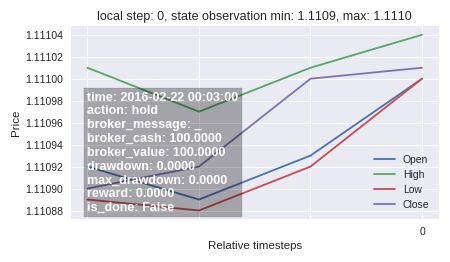

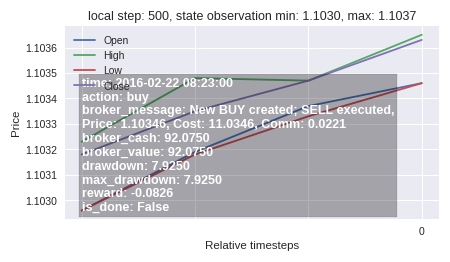

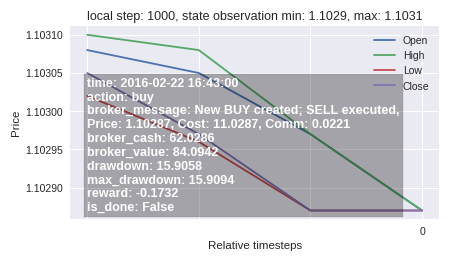

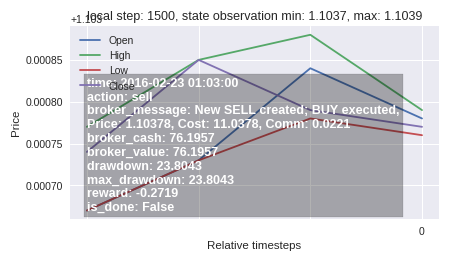

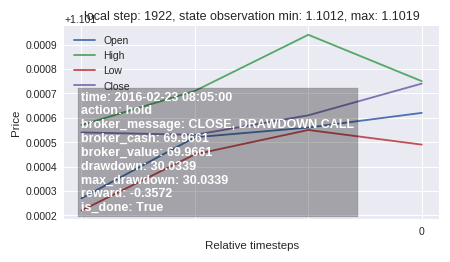

SUMMARY:
episode: 0
runtime: 0:00:02.911262
length: 1926

INFO [last observation]:
step: 1922
time: 2016-02-23 08:05:00
action: hold
broker_message: CLOSE, DRAWDOWN CALL
broker_cash: 69.9661
broker_value: 69.9661
drawdown: 30.0339
max_drawdown: 30.0339

BACKTRADER SUMMARY PLOT:


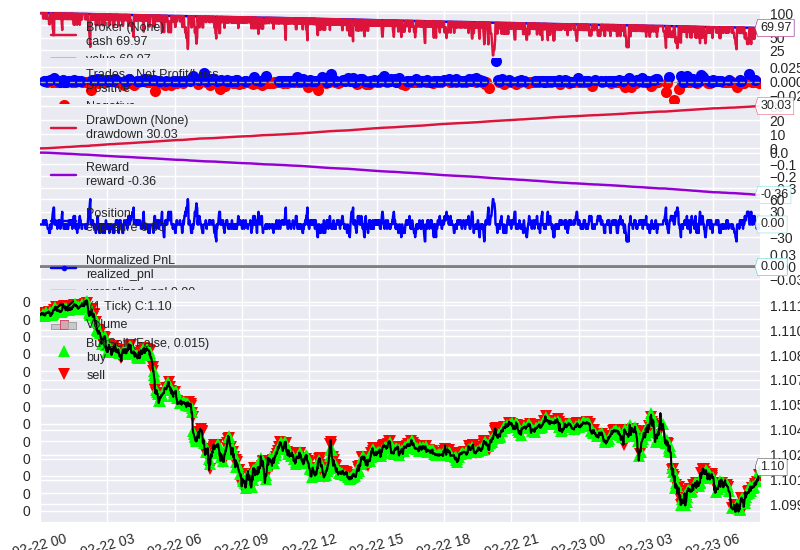

[2018-07-21 19:38:24.265518] INFO: BTgymServer_0: Requesting new Trial sample with args: {'get_new': True, 'sample_type': 0, 'timestamp': None, 'b_alpha': 1, 'b_beta': 1}
[2018-07-21 19:38:24.271392] INFO: SimpleDataSet_0: New sample id: <train_trial_w_0_num_1_at_2016-08-09>.
[2018-07-21 19:38:24.303833] INFO: BTgymServer_0: Requesting episode from <train_trial_w_0_num_1_at_2016-08-09> with args: {'get_new': True, 'sample_type': 0, 'timestamp': 1451840460.0, 'b_alpha': 1, 'b_beta': 1}
[2018-07-21 19:38:24.307045] INFO: Trial_0: New sample id: <train_episode_w_0_num_0_at_2016-08-09>.

EPISODE [2]:


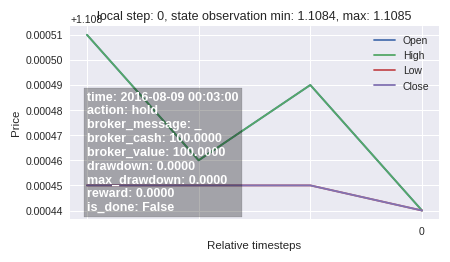

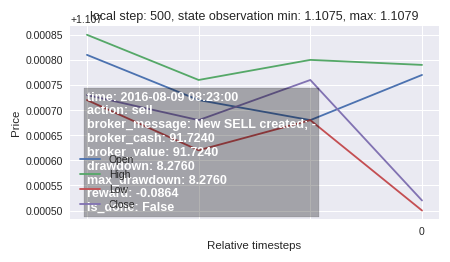

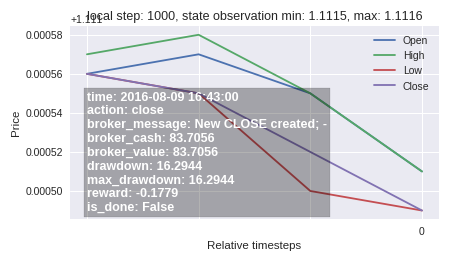

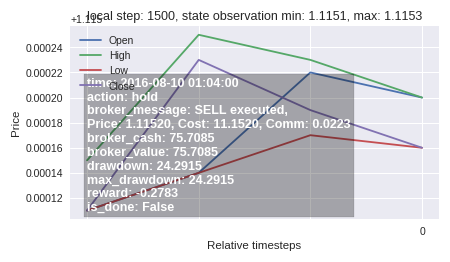

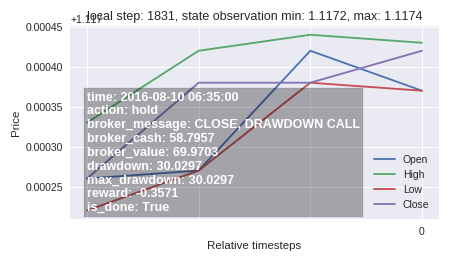

SUMMARY:
episode: 1
runtime: 0:00:02.636571
length: 1835

INFO [last observation]:
step: 1831
time: 2016-08-10 06:35:00
action: hold
broker_message: CLOSE, DRAWDOWN CALL
broker_cash: 58.7957
broker_value: 69.9703
drawdown: 30.0297
max_drawdown: 30.0297

BACKTRADER SUMMARY PLOT:


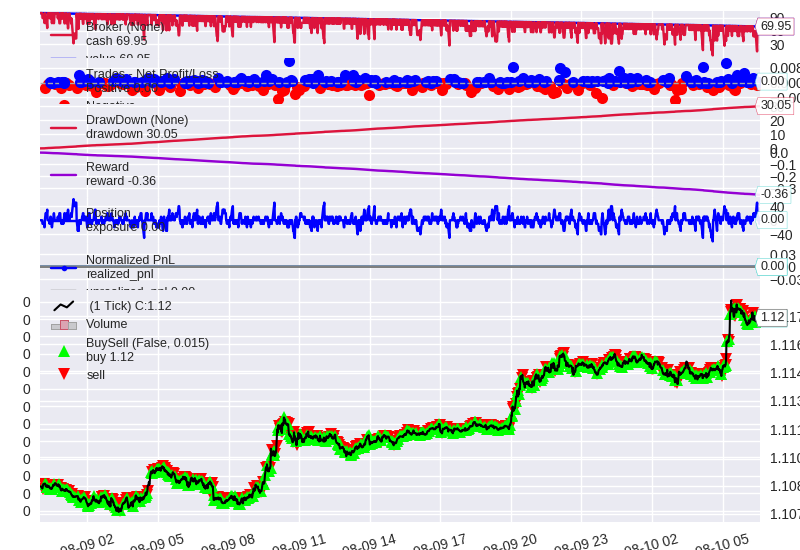

[2018-07-21 19:38:27.018605] INFO: BTgymServer_0: Exiting.
[2018-07-21 19:38:27.020019] INFO: BTgymAPIshell_0: Exiting. Exit code: None
[2018-07-21 19:38:27.021056] INFO: BTgymDataServer_0: {'ctrl': 'Exiting.'}
[2018-07-21 19:38:27.022035] INFO: BTgymAPIshell_0: {'ctrl': 'Exiting.'} Exit code: None
[2018-07-21 19:38:27.023339] INFO: BTgymAPIshell_0: Environment closed.


In [6]:
# Run it:
for episode in range(num_episodes):
    
    # Calling reset() before every episode.

    init_state = MyEnvironment.reset()
    
    print('\nEPISODE [{}]:'.format(episode + 1))
    
    # Render and show first step:
    show_rendered_image(MyEnvironment.render('human'))
    
    # Repeat until episode end:
    for _ in itertools.count(): 
        
        #Choose random action:
        rnd_action = MyEnvironment.action_space.sample()
        
        # Make a step in the environment:
        obs, reward, done, info = MyEnvironment.step(rnd_action)
        
        # Show state every 500th step
        # and when episode is finished:
        if info[-1]['step'] % state_render == 0 or done:
            show_rendered_image(MyEnvironment.render('human'))
                
        if done: break
            
    # Print episode statistic (quite modest for now since we didn't added any observers etc.)
    print('SUMMARY:\n{}\nINFO [last observation]:\n{}'.
        format(to_string(MyEnvironment.get_stat()), to_string(info[-1])))
    # Render and show episode statisic:
    print('BACKTRADER SUMMARY PLOT:')
    show_rendered_image(MyEnvironment.render('episode'))

# Clean up:
MyEnvironment.close()

In [7]:
MyEnvironment.close()

[2018-07-21 19:38:32.398753] INFO: BTgymAPIshell_0: No running server found. Hint: forgot to call reset()?
[2018-07-21 19:38:32.400248] INFO: BTgymAPIshell_0: Server process terminated. Exit code: 0
[2018-07-21 19:38:32.401996] INFO: BTgymAPIshell_0: Data_server process terminated. Exit code: 0
[2018-07-21 19:38:32.405959] INFO: BTgymAPIshell_0: Environment closed.
